# DL Project
## Stock Market Prediction 
In this project we will try to predict the stock market value using the dataset Stock Market Data of USA. 
We will use the LSTM model to predict the values of future stocks

**Index**: stock market index
**Date**: date of information recorded
**Open**: the price at which a stock starts trading.
**High**: show the high price a stock attained for a particular period of time.
**Low**: show the low price a stock attained for a particular period of time.
**Close**: The close is a reference to the end of a trading session in the financial markets when the markets close for the day
**Adj Close**: It is the price at which the last of the stock is bought or sold in the last trading session.
**Volume**: Volume is simply the number of shares traded in a particular stock, index, or other investment over a specific period of time.




In [23]:
import pandas as pd

data = pd.read_excel('DL_Dataset.xlsx')

print(data)

       Index                 Date         Open         High          Low  \
0        NYA           12/31/1965   528.690002   528.690002   528.690002   
1        NYA  1966-03-01 00:00:00   527.210022   527.210022   527.210022   
2        NYA  1966-04-01 00:00:00   527.840027   527.840027   527.840027   
3        NYA  1966-05-01 00:00:00   531.119995   531.119995   531.119995   
4        NYA  1966-06-01 00:00:00   532.070007   532.070007   532.070007   
...      ...                  ...          ...          ...          ...   
112452  N100            5/27/2021  1241.119995  1251.910034  1241.119995   
112453  N100            5/28/2021  1249.469971  1259.209961  1249.030029   
112454  N100            5/31/2021  1256.079956  1258.880005  1248.140015   
112455  N100  2021-01-06 00:00:00  1254.609985  1265.660034  1254.609985   
112456  N100  2021-02-06 00:00:00  1258.489990  1263.709961  1258.239990   

              Close    Adj Close       Volume  
0        528.690002   528.690002       

In [24]:
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # Converte a coluna 'Date' para datetime

## Retirar duplicados e NA's

In [25]:
data = data.dropna() # Remover valores nulos do 
data = data.drop_duplicates()

## Outliers


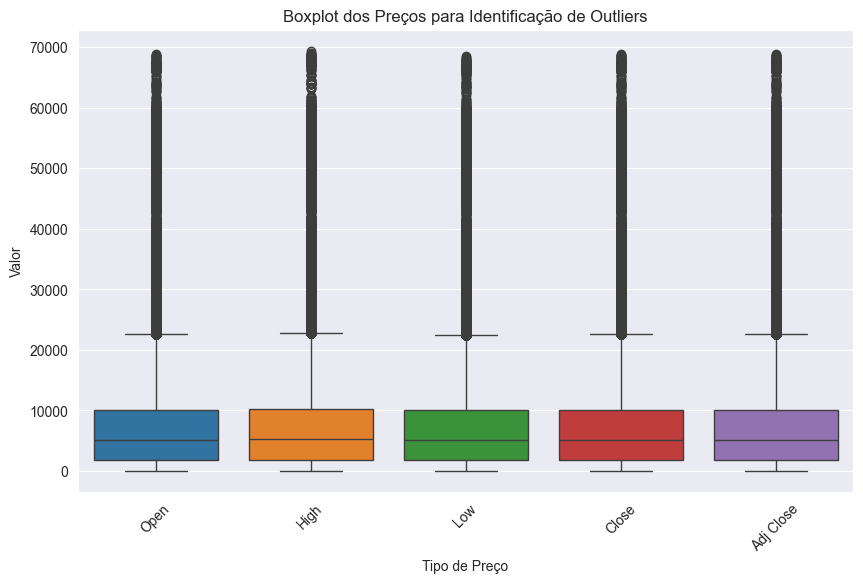

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecione apenas as colunas relevantes (preços)
price_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close']

# Criar um gráfico boxplot para visualizar outliers
plt.figure(figsize=(10,6))
sns.boxplot(data=data[price_columns])
plt.title('Boxplot dos Preços para Identificação de Outliers')
plt.xlabel('Tipo de Preço')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.show()

Depois de verificar estes graficos, decidimos retirar os outliers

In [27]:
# Definir as colunas que você quer verificar
price_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Calcular o IQR para cada coluna
Q1 = data[price_columns].quantile(0.25)
Q3 = data[price_columns].quantile(0.75)
IQR = Q3 - Q1

# Filtrar para manter apenas os dados dentro do intervalo
data_clean = data[~((data[price_columns] < (Q1 - 1.5 * IQR)) | (data[price_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"Antes de remover outliers: {data.shape}")
print(f"Depois de remover outliers: {data_clean.shape}")

Antes de remover outliers: (110238, 8)
Depois de remover outliers: (84698, 8)


Aqui verificamos alguns dados estatisticos do dataset

In [28]:
data_clean.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,84698,84698.000000,84698.000000,84698.000000,84698.000000,84698.000000,8.469800e+04
mean,2000-01-20 16:22:38.426408960,5392.224410,5425.848884,5355.061456,5391.350208,5391.162414,3.769470e+07
min,1965-01-02 00:00:00,54.869999,54.869999,54.869999,54.869999,54.869999,0.000000e+00
25%,1990-10-22 00:00:00,1433.247498,1436.859985,1428.772522,1433.232483,1433.102539,0.000000e+00
50%,2001-12-04 00:00:00,3745.364991,3769.000000,3722.919921,3745.050049,3743.963501,8.140000e+04
75%,2011-08-17 00:00:00,8335.489746,8383.727783,8272.197266,8329.139893,8329.139893,4.398630e+07
max,2021-12-05 00:00:00,22551.939450,22683.400390,22381.009770,22553.720700,22553.720700,4.336000e+08
std,NaN,4910.325292,4943.551244,4873.295850,4909.177062,4909.268817,7.630873e+07


In [29]:
# Passar todos os valores para 2 casas decimais
data_clean['Open'] = data_clean['Open'].round(2)
data_clean['High'] = data_clean['High'].round(2)
data_clean['Low'] = data_clean['Low'].round(2)
data_clean['Close'] = data_clean['Close'].round(2)
data_clean['Volume'] = data_clean['Volume'].round(2)
data_clean['Adj Close'] = data_clean['Adj Close'].round(2)
print(data_clean)

       Index       Date     Open     High      Low    Close  Adj Close  \
0        NYA 1965-12-31   528.69   528.69   528.69   528.69     528.69   
1        NYA 1966-03-01   527.21   527.21   527.21   527.21     527.21   
2        NYA 1966-04-01   527.84   527.84   527.84   527.84     527.84   
3        NYA 1966-05-01   531.12   531.12   531.12   531.12     531.12   
4        NYA 1966-06-01   532.07   532.07   532.07   532.07     532.07   
...      ...        ...      ...      ...      ...      ...        ...   
112452  N100 2021-05-27  1241.12  1251.91  1241.12  1247.07    1247.07   
112453  N100 2021-05-28  1249.47  1259.21  1249.03  1256.60    1256.60   
112454  N100 2021-05-31  1256.08  1258.88  1248.14  1248.93    1248.93   
112455  N100 2021-01-06  1254.61  1265.66  1254.61  1258.58    1258.58   
112456  N100 2021-02-06  1258.49  1263.71  1258.24  1263.62    1263.62   

             Volume  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4

/var/folders/26/7s9y6vdj3xs20whynm5xn0500000gn/T/ipykernel_75055/1078004843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['Open'] = data_clean['Open'].round(2)
/var/folders/26/7s9y6vdj3xs20whynm5xn0500000gn/T/ipykernel_75055/1078004843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['High'] = data_clean['High'].round(2)
/var/folders/26/7s9y6vdj3xs20whynm5xn0500000gn/T/ipykernel_75055/1078004843.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

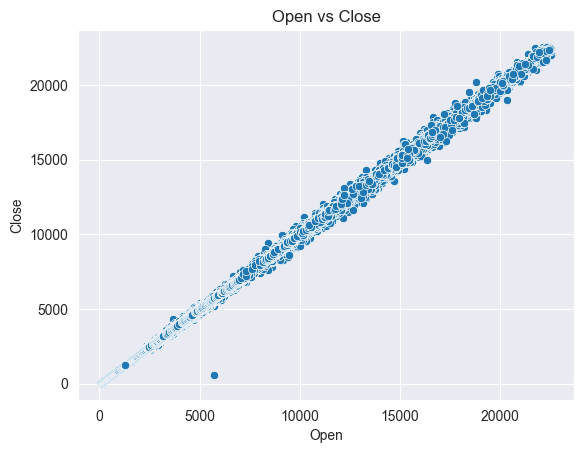

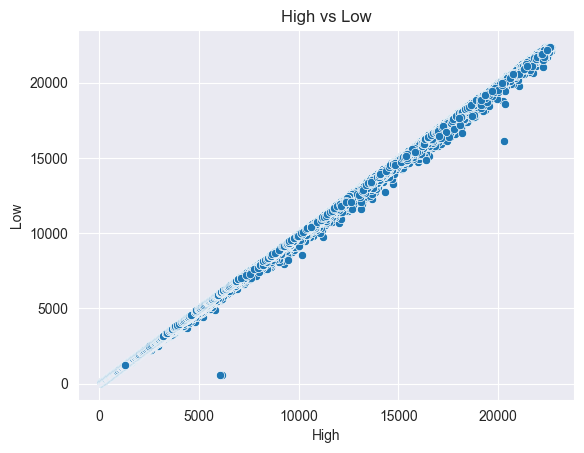

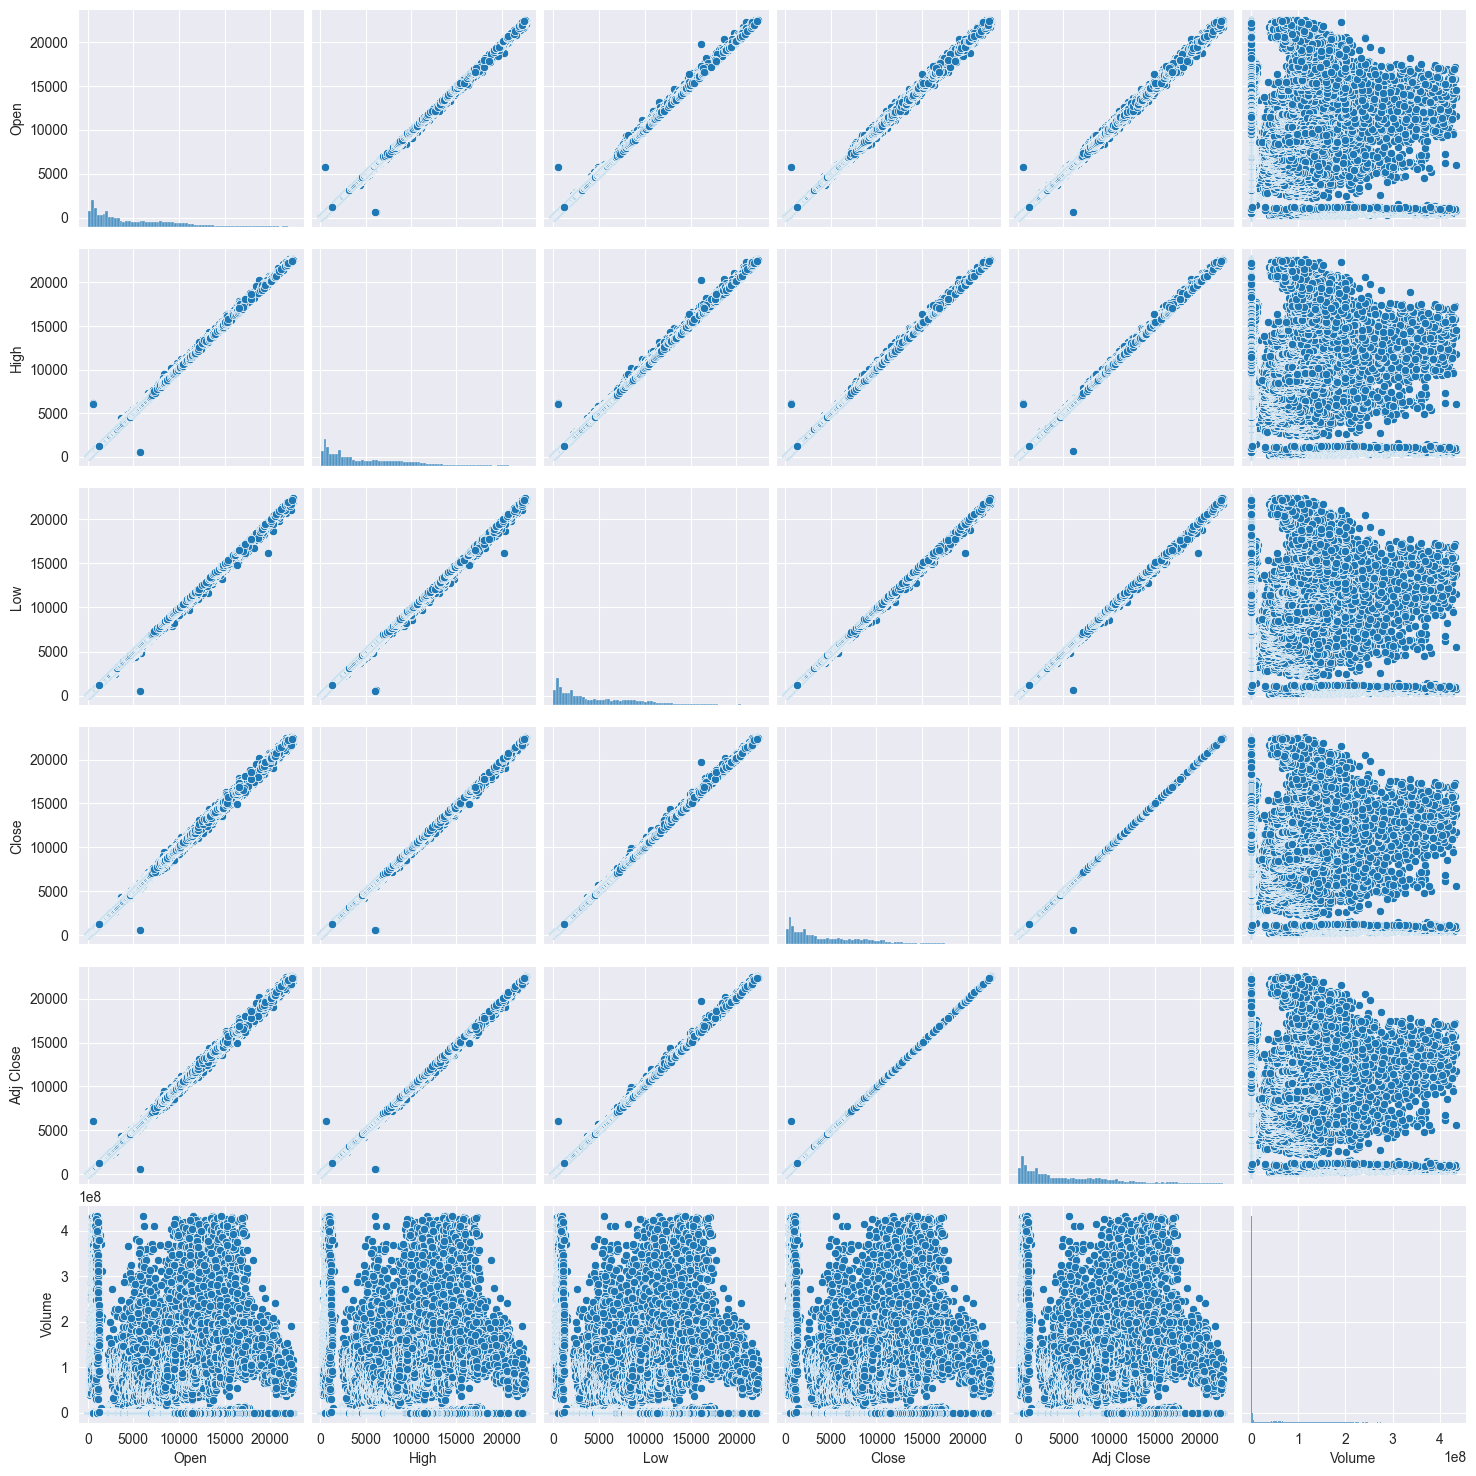

In [30]:
import matplotlib.pyplot as plt 
import seaborn as sns

sns.scatterplot(data = data_clean, x = 'Open', y = 'Close')
plt.title('Open vs Close')
plt.show()
sns.scatterplot(data = data_clean, x = 'High', y = 'Low')
plt.title('High vs Low')
plt.show()
sns.pairplot(data = data_clean)
plt.show()

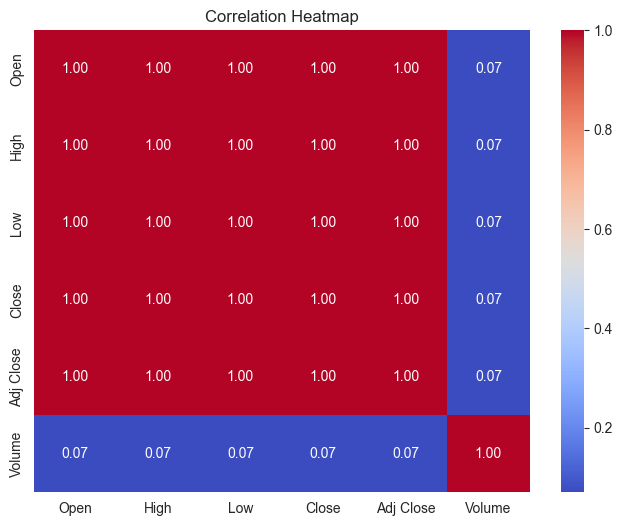

In [31]:
import seaborn as sns
import numpy as np

# Cálculo da correlação
corr = data_clean[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()

# Criação do heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [32]:
from sklearn.model_selection import train_test_split

y = data_clean[['Open', 'Close']]
X = data_clean.drop(columns=['Open', 'Close'])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
x_train.shape, x_test.shape

((59288, 6), (25410, 6))

## Normalização

In [33]:
from sklearn.preprocessing import MinMaxScaler

# Inicializando os escaladores
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Removendo as colunas 'Index' e 'Date' apenas para a normalização
x_train_scaled = scaler_X.fit_transform(x_train.drop(columns=['Index', 'Date']))
x_test_scaled = scaler_X.transform(x_test.drop(columns=['Index', 'Date']))

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Verificando as dimensões dos dados escalonados
print(f"Tamanho de x_train_scaled: {x_train_scaled.shape}, Tamanho de x_test_scaled: {x_test_scaled.shape}")
print(f"Tamanho de y_train_scaled: {y_train_scaled.shape}, Tamanho de y_test_scaled: {y_test_scaled.shape}")

Tamanho de x_train_scaled: (59288, 4), Tamanho de x_test_scaled: (25410, 4)
Tamanho de y_train_scaled: (59288, 2), Tamanho de y_test_scaled: (25410, 2)


## Converter os dados para o formato adequado para o LSTM

In [34]:
def create_dataset(X, y, time_step=60):
    """
    Converte os dados em sequências de forma que cada sequência tenha `time_step` entradas
    e um valor correspondente de saída para o próximo período.
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - time_step):
        X_seq.append(X[i:(i + time_step), :])  # Sequência de entradas
        y_seq.append(y[i + time_step, :])      # Valor alvo para o próximo período
    return np.array(X_seq), np.array(y_seq)

# Criando as sequências para os dados de treino e teste
X_train_seq, y_train_seq = create_dataset(x_train_scaled, y_train_scaled, time_step=3000)
X_test_seq, y_test_seq = create_dataset(x_test_scaled, y_test_scaled, time_step=3000)

# Verificando as novas dimensões das sequências
print(f"Shape de X_train_seq: {X_train_seq.shape}, Shape de y_train_seq: {y_train_seq.shape}")


Shape de X_train_seq: (56288, 3000, 4), Shape de y_train_seq: (56288, 2)


## Construir o modelo LSTM 

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Construindo o modelo LSTM
model = Sequential()

# Adicionando uma camada LSTM
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))

# Adicionando uma camada densa para gerar a saída
model.add(Dense(units=2))  # 'Open' e 'Close' são as duas variáveis que queremos prever

# Compilando o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Resumo do modelo
model.summary()


/Users/beatrizdias/anaconda3/envs/ML_ADS/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,102 (43.37 KB)

 Trainable params: 11,102 (43.37 KB)

 Non-trainable params: 0 (0.00 B)

## Treinar o Modelo 

In [36]:
# Treinando o modelo
model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_data=(X_test_seq, y_test_seq))

Epoch 1/10
 354/1759 ━━━━━━━━━━━━━━━━━━━━ 6:14 267ms/step - loss: 0.0547

KeyboardInterrupt: 

## Fazer as previsões e calcular a Loss e o RMSE

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Fazendo previsões com o conjunto de teste
predictions = model.predict(X_test_seq)

# Desnormalizando as previsões e os valores reais
predictions = scaler_y.inverse_transform(predictions)
y_test_real = scaler_y.inverse_transform(y_test_seq)

# Calculando a loss (Erro Quadrático Médio)
loss = mean_squared_error(y_test_real, predictions)

# Calculando o RQM (Root Mean Squared Error)
rmse = np.sqrt(loss)

# Exemplo: comparando a previsão para o primeiro dia do conjunto de teste
print("Previsão (Open, Close): ", predictions[0])
print("Real (Open, Close): ", y_test_real[0])

# Exibindo a loss e o RQM
print(f"Loss (MSE): {loss}")
print(f"RMSE: {rmse}")

# Visualizando os resultados (gráfico)
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test_real[:, 0], label="Real Open")  # Valores reais de 'Open'
plt.plot(predictions[:, 0], label="Predicted Open")  # Previsões de 'Open'
plt.legend()
plt.show()